In [32]:
import os
import cv2
import pandas as pd
import tf_keras
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt

In [33]:
train_df = pd.read_csv("/kaggle/input/ai-vs-human-generated-dataset/train.csv")
test_df = pd.read_csv("/kaggle/input/ai-vs-human-generated-dataset/test.csv")

In [34]:
train_df.head()

Unnamed: 0                                        file_name  label
0           0  train_data/a6dcb93f596a43249135678dfcfc17ea.jpg      1
1           1  train_data/041be3153810433ab146bc97d5af505c.jpg      0
2           2  train_data/615df26ce9494e5db2f70e57ce7a3a4f.jpg      1
3           3  train_data/8542fe161d9147be8e835e50c0de39cd.jpg      0
4           4  train_data/5d81fa12bc3b4cea8c94a6700a477cf2.jpg      1

In [35]:
test_df.head()

id
0  test_data_v2/1a2d9fd3e21b4266aea1f66b30aed157.jpg
1  test_data_v2/ab5df8f441fe4fbf9dc9c6baae699dc7.jpg
2  test_data_v2/eb364dd2dfe34feda0e52466b7ce7956.jpg
3  test_data_v2/f76c2580e9644d85a741a42c6f6b39c0.jpg
4  test_data_v2/a16495c578b7494683805484ca27cf9f.jpg

In [36]:
DATASET_PATH = "/kaggle/input/ai-vs-human-generated-dataset"

train_file_paths = [os.path.join(DATASET_PATH, fname) for fname in train_df['file_name']]
train_labels = train_df['label'].values

test_file_paths = [os.path.join(DATASET_PATH, fname) for fname in test_df['id']]

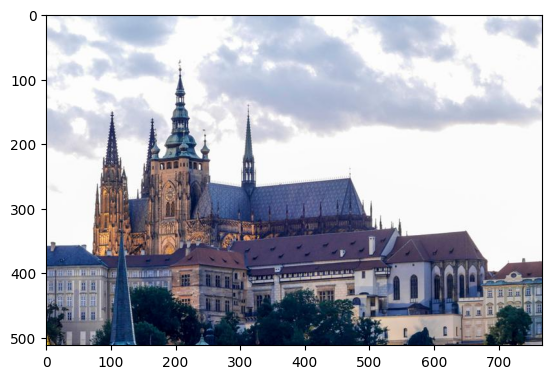

In [37]:
import random

idx = random.randint(0, 100)
check_img_path = train_file_paths[idx]
image = cv2.imread(check_img_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)

In [38]:
train_df["file_name"] = train_file_paths
train_df.head()

Unnamed: 0                                          file_name  label
0           0  /kaggle/input/ai-vs-human-generated-dataset/tr...      1
1           1  /kaggle/input/ai-vs-human-generated-dataset/tr...      0
2           2  /kaggle/input/ai-vs-human-generated-dataset/tr...      1
3           3  /kaggle/input/ai-vs-human-generated-dataset/tr...      0
4           4  /kaggle/input/ai-vs-human-generated-dataset/tr...      1

In [39]:
test_df["id"] = test_file_paths
test_df.head()

id
0  /kaggle/input/ai-vs-human-generated-dataset/te...
1  /kaggle/input/ai-vs-human-generated-dataset/te...
2  /kaggle/input/ai-vs-human-generated-dataset/te...
3  /kaggle/input/ai-vs-human-generated-dataset/te...
4  /kaggle/input/ai-vs-human-generated-dataset/te...

In [40]:
train_df.label.value_counts()

label
1    39975
0    39975
Name: count, dtype: int64

In [41]:
def show_ai_vs_human(df, num_images=5):
    ai_images = df[df["label"] == 1]["file_name"].dropna().sample(num_images, random_state=42).values
    human_images = df[df["label"] == 0]["file_name"].dropna().sample(num_images, random_state=42).values

    plt.figure(figsize=(15, num_images * 2))
    
    for i, (ai_img_path, human_img_path) in enumerate(zip(ai_images, human_images)):
        ai_img = cv2.imread(ai_img_path)
        human_img = cv2.imread(human_img_path)

        if ai_img is None or human_img is None:
            print(f"Skipping missing images: {ai_img_path} or {human_img_path}")
            continue  # Skip missing images
        
        ai_img = cv2.cvtColor(ai_img, cv2.COLOR_BGR2RGB)
        human_img = cv2.cvtColor(human_img, cv2.COLOR_BGR2RGB)

        plt.subplot(num_images, 2, i * 2 + 1)
        plt.imshow(human_img)
        plt.axis("off")
        plt.title("Human-Created")

        plt.subplot(num_images, 2, i * 2 + 2)
        plt.imshow(ai_img)
        plt.axis("off")
        plt.title("AI-Generated")

    plt.suptitle("AI vs Human-Generated Images", fontsize=16)
    plt.tight_layout()
    plt.show()

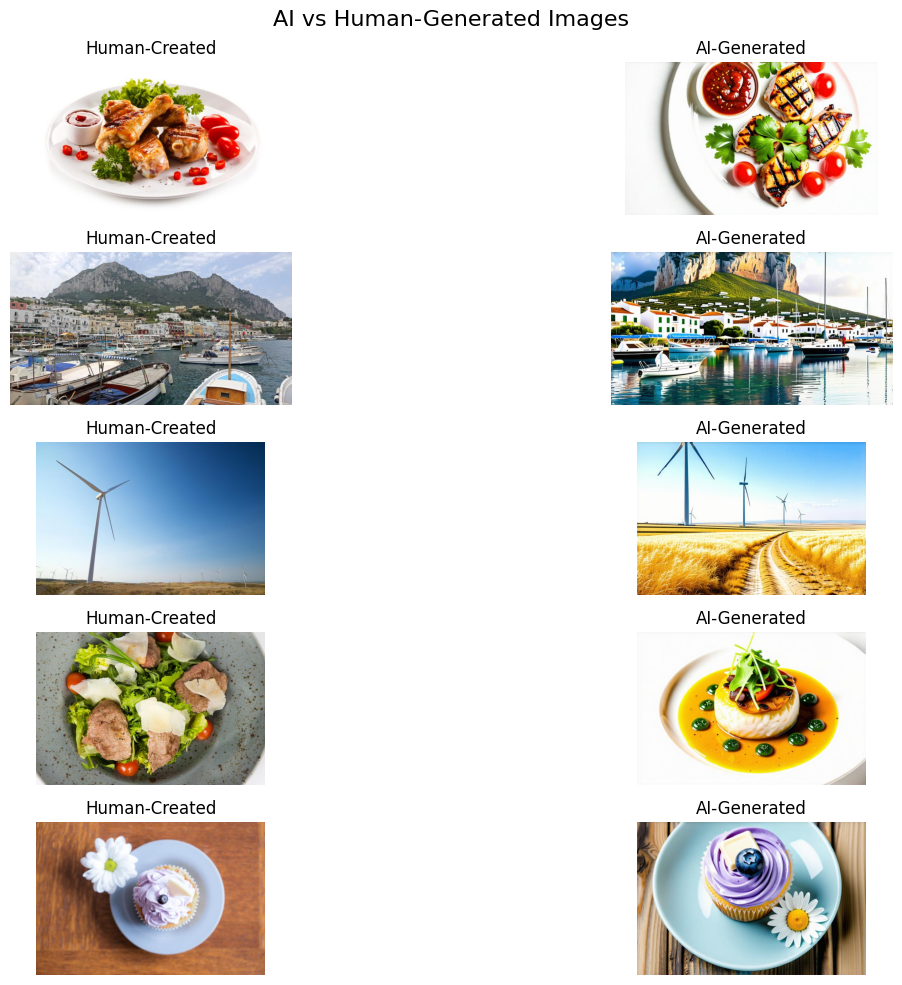

In [42]:
show_ai_vs_human(train_df)

In [43]:
import seaborn as sns

def get_image_dimensions(image_paths, sample_size=500):
    image_sizes = []
    
    for img_path in image_paths.sample(sample_size, random_state=42):
        img = cv2.imread(img_path)
        if img is not None:
            h, w, _ = img.shape
            image_sizes.append((w, h))
    
    return pd.DataFrame(image_sizes, columns=["Width", "Height"])

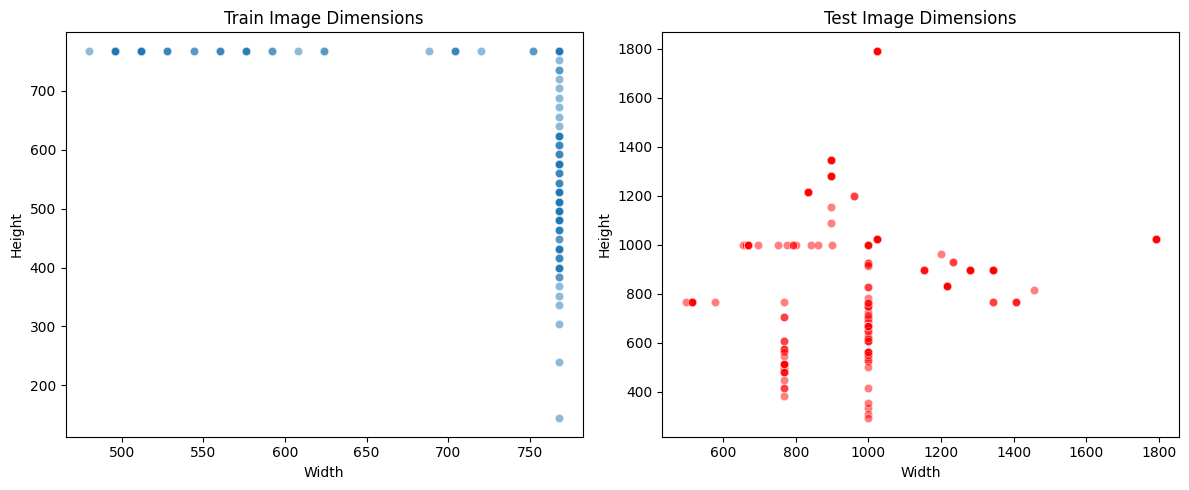

In [44]:
train_size_df = get_image_dimensions(train_df["file_name"])
test_size_df = get_image_dimensions(test_df["id"])

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.scatterplot(x=train_size_df["Width"], y=train_size_df["Height"], alpha=0.5, ax=axes[0])
axes[0].set_title("Train Image Dimensions")
axes[0].set_xlabel("Width")
axes[0].set_ylabel("Height")

sns.scatterplot(x=test_size_df["Width"], y=test_size_df["Height"], alpha=0.5, ax=axes[1], color='red')
axes[1].set_title("Test Image Dimensions")
axes[1].set_xlabel("Width")
axes[1].set_ylabel("Height")

plt.tight_layout()
plt.show()

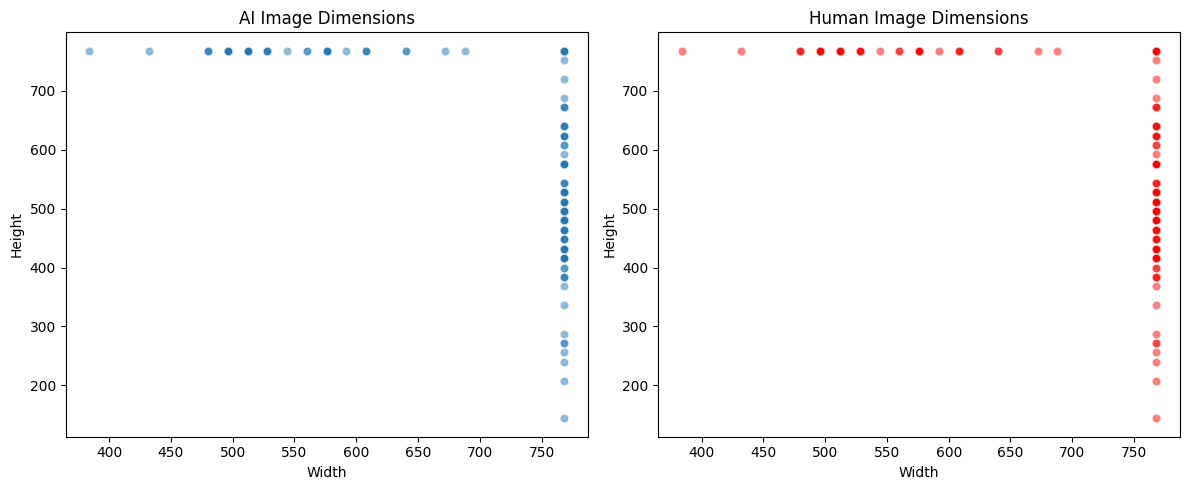

In [45]:
ai_images = train_df[train_df["label"] == 1]["file_name"]
human_images = train_df[train_df["label"] == 0]["file_name"]

ai_size_df = get_image_dimensions(ai_images)
human_size_df = get_image_dimensions(human_images)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.scatterplot(x=human_size_df["Width"], y=human_size_df["Height"], alpha=0.5, ax=axes[0])
axes[1].set_title("Human Image Dimensions")
axes[1].set_xlabel("Width")
axes[1].set_ylabel("Height")

sns.scatterplot(x=ai_size_df["Width"], y=ai_size_df["Height"], alpha=0.5, ax=axes[1], color='red')
axes[0].set_title("AI Image Dimensions")
axes[0].set_xlabel("Width")
axes[0].set_ylabel("Height")

plt.tight_layout()
plt.show()

In [46]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(
    train_df,  
    test_size=0.05,        
    stratify=train_df['label'],
    random_state=42
)

print(f"Train Data: {len(train_df)}")
print(f"Validation Data: {len(val_df)}")
print(f"Test Data: {len(test_df)}")

Train Data: 75952
Validation Data: 3998
Test Data: 5540


In [47]:
train_file_paths = train_df["file_name"].values
train_labels = train_df["label"].values

val_file_paths = val_df["file_name"].values
val_labels = val_df["label"].values

In [48]:
IMG_HEIGHT = 224
IMG_WIDTH = 224

def process_path(file_path, label):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (IMG_HEIGHT, IMG_WIDTH))
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

train_ds = tf.data.Dataset.from_tensor_slices((train_file_paths, train_labels))
train_ds = train_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(1000).batch(64).prefetch(tf.data.experimental.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((val_file_paths, val_labels))
val_ds = val_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.shuffle(1000).batch(64).prefetch(tf.data.experimental.AUTOTUNE)

Maximum pixel value: 1.0


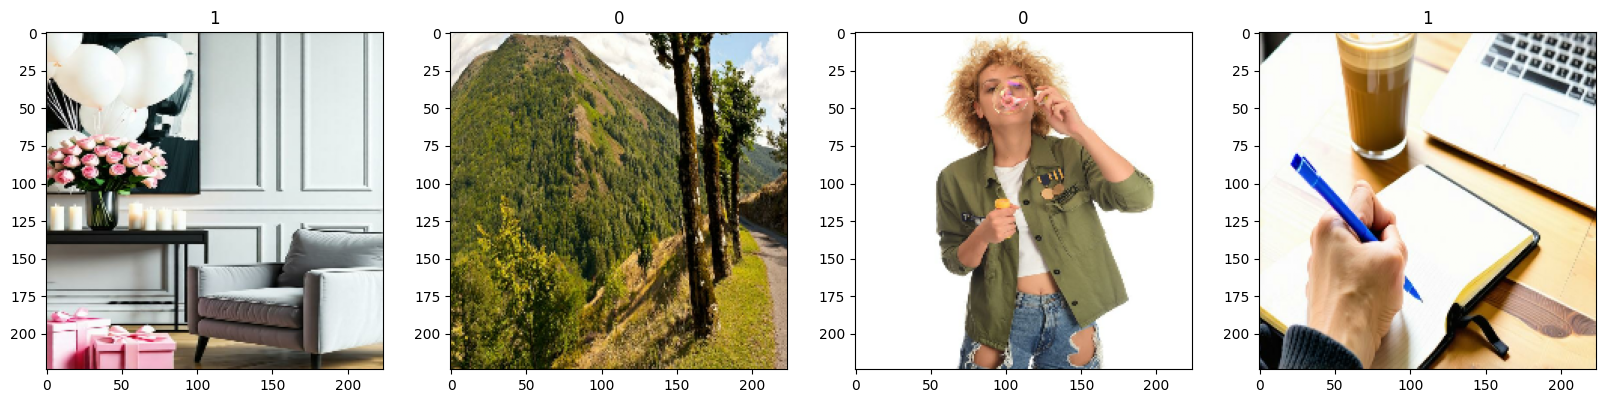

In [49]:
data_iterator = train_ds.as_numpy_iterator()
batch = next(data_iterator)

print("Maximum pixel value:", batch[0].max())

fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].set_title(batch[1][idx])
plt.show()

Maximum pixel value: 1.0


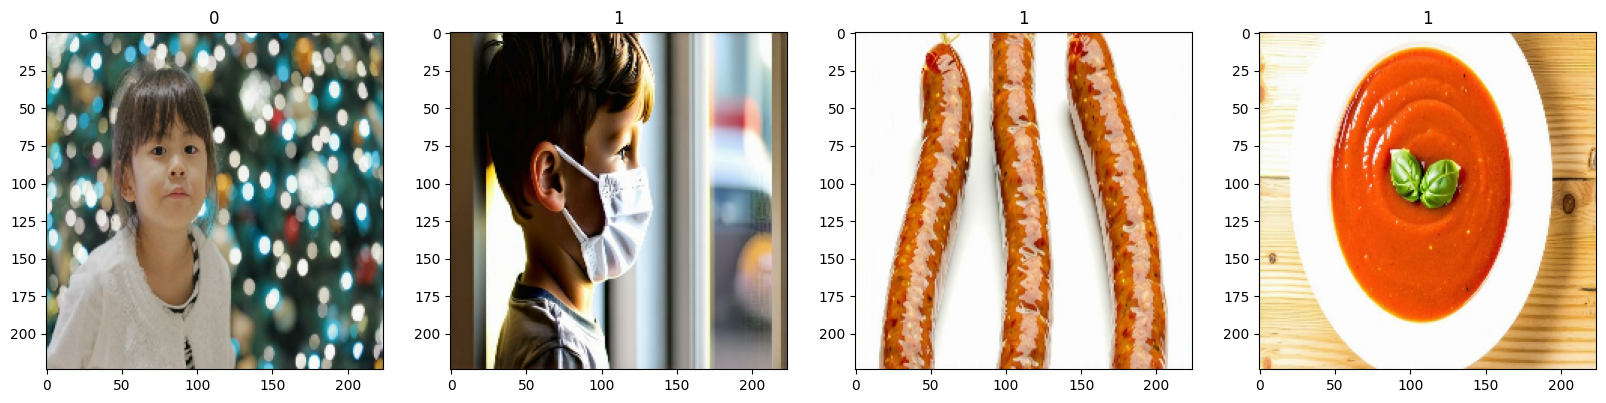

In [50]:
data_iterator = val_ds.as_numpy_iterator()
batch = next(data_iterator)

print("Maximum pixel value:", batch[0].max())

fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].set_title(batch[1][idx])
plt.show()

In [58]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import InceptionV3

base_model = InceptionV3(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model.trainable = False

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [59]:
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(1, activation="sigmoid")
])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)            │ (None, 5, 5, 2048)          │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,983,457 (87.67 MB)

 Trainable params: 1,180,673 (4.50 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [60]:
model.compile(
    optimizer='adam',
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

In [61]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint("best_model.keras", save_best_only=True, monitor="val_accuracy", mode="max")

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    # callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/15
1187/1187 ━━━━━━━━━━━━━━━━━━━━ 220s 166ms/step - accuracy: 0.7289 - loss: 0.5450 - val_accuracy: 0.8247 - val_loss: 0.3830
Epoch 2/15
1187/1187 ━━━━━━━━━━━━━━━━━━━━ 174s 145ms/step - accuracy: 0.8231 - loss: 0.3914 - val_accuracy: 0.8342 - val_loss: 0.3683
Epoch 3/15
1187/1187 ━━━━━━━━━━━━━━━━━━━━ 174s 146ms/step - accuracy: 0.8337 - loss: 0.3651 - val_accuracy: 0.8402 - val_loss: 0.3606
Epoch 4/15
1187/1187 ━━━━━━━━━━━━━━━━━━━━ 174s 146ms/step - accuracy: 0.8441 - loss: 0.3496 - val_accuracy: 0.8384 - val_loss: 0.3521
Epoch 5/15
1187/1187 ━━━━━━━━━━━━━━━━━━━━ 173s 144ms/step - accuracy: 0.8523 - loss: 0.3344 - val_accuracy: 0.8434 - val_loss: 0.3442
Epoch 6/15
1187/1187 ━━━━━━━━━━━━━━━━━━━━ 202s 145ms/step - accuracy: 0.8582 - loss: 0.3236 - val_accuracy: 0.8514 - val_loss: 0.3357
Epoch 7/15
1187/1187 ━━━━━━━━━━━━━━━━━━━━ 174s 146ms/step - accuracy: 0.8643 - loss: 0.3098 - val_accuracy: 0.8567 - val_loss: 0.3265
Epoch 8/15
1187/1187 ━━━━━━━━━━━━━━━━━━━━ 173s 145ms/step - ac

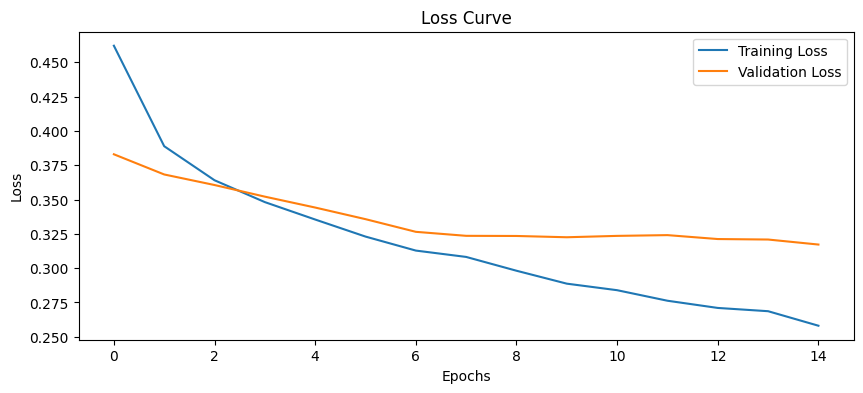

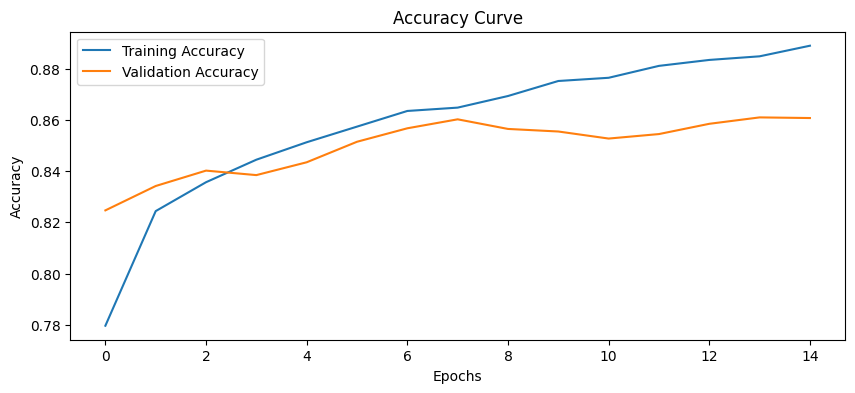

In [62]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert history to DataFrame for easy plotting
history_df = pd.DataFrame(history.history)

# Plot Loss Curve
plt.figure(figsize=(10, 4))
plt.plot(history_df["loss"], label="Training Loss")
plt.plot(history_df["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curve")
plt.show()

# Plot Accuracy Curve
plt.figure(figsize=(10, 4))
plt.plot(history_df["accuracy"], label="Training Accuracy")
plt.plot(history_df["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy Curve")
plt.show()

In [63]:
train_loss, train_accuracy = model.evaluate(train_ds)
print(f"Accuracy on train data: {train_accuracy:.2%} | Loss: {train_loss:.4f}")

1187/1187 ━━━━━━━━━━━━━━━━━━━━ 166s 139ms/step - accuracy: 0.9104 - loss: 0.2228
Accuracy on train data: 91.32% | Loss: 0.2185


In [69]:
import numpy as np
val_predictions = model.predict(val_ds).flatten()  # Ensure 1D array
print(f"Min: {np.min(val_predictions)}, Max: {np.max(val_predictions)}, Mean: {np.mean(val_predictions)}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 124ms/step
Min: 6.529127460908057e-09, Max: 0.9999736547470093, Mean: 0.5103465914726257


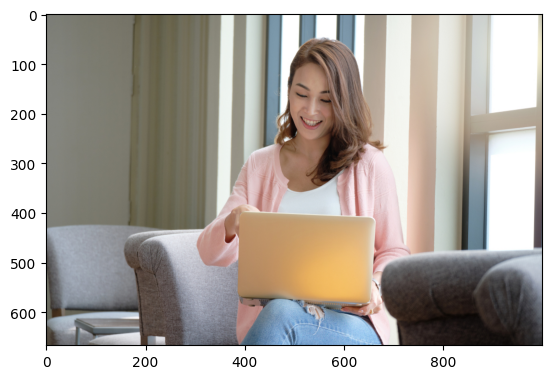

In [70]:
import random

idx = random.randint(0, 100)
check_img_path = test_file_paths[idx]
image = cv2.imread(check_img_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)

In [73]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_generator = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

test_generator = data_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col="id",   
    y_col=None,         
    target_size=(224, 224),  
    batch_size=32,
    class_mode=None,     
    shuffle=False        
)

Found 5540 validated image filenames.


In [74]:
predictions = model.predict(test_generator)
predicted_labels = (predictions > 0.5).astype(int) 

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


174/174 ━━━━━━━━━━━━━━━━━━━━ 184s 1s/step


In [76]:
test_results = pd.DataFrame({
    'id': test_df['id'],  
    'label': predicted_labels.flatten()  
})

test_results.head()

id  label
0  /kaggle/input/ai-vs-human-generated-dataset/te...      1
1  /kaggle/input/ai-vs-human-generated-dataset/te...      0
2  /kaggle/input/ai-vs-human-generated-dataset/te...      1
3  /kaggle/input/ai-vs-human-generated-dataset/te...      0
4  /kaggle/input/ai-vs-human-generated-dataset/te...      0

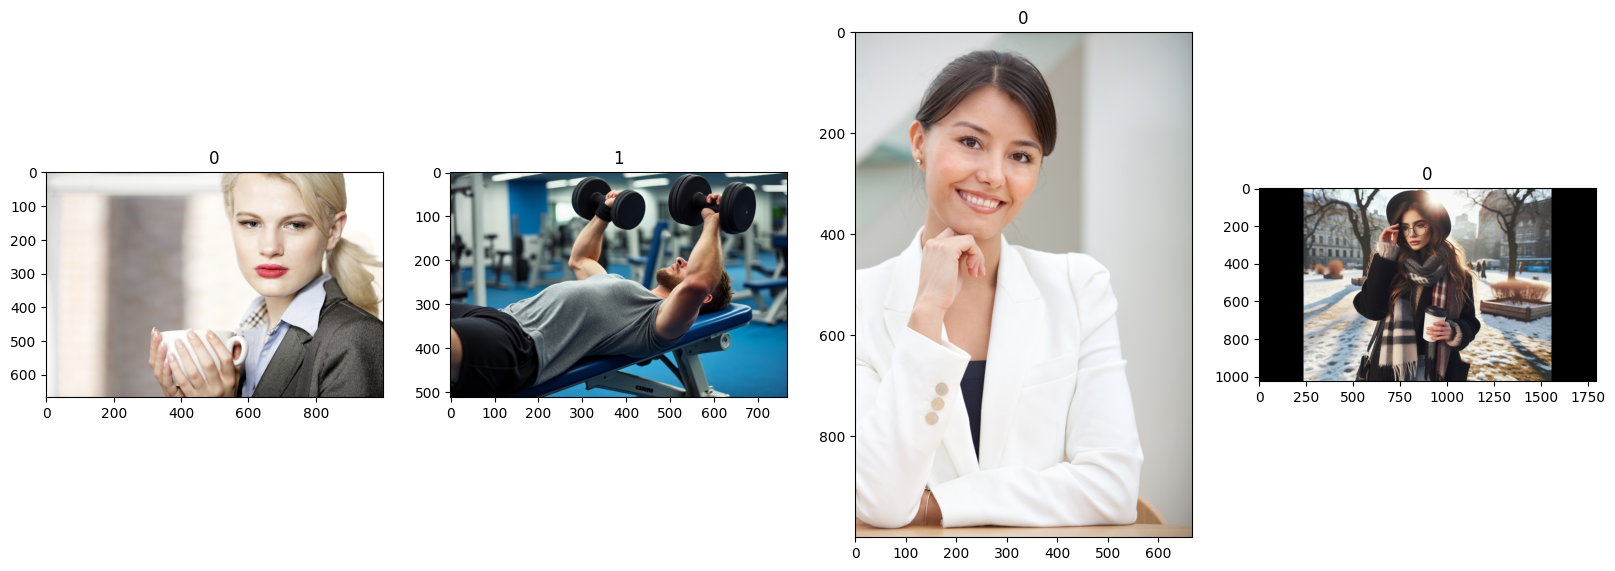

In [94]:
from PIL import Image

test_img_paths = test_results['id'].values
test_labels = test_results['label'].values

shuffle_indices = np.random.permutation(25)
test_img_paths = test_img_paths[shuffle_indices]
test_labels = test_labels[shuffle_indices]

fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, (img_path, label) in enumerate(zip(test_img_paths, test_labels)):
    if idx == 4:
        break
    img = Image.open(img_path)
    ax[idx].imshow(img)
    ax[idx].set_title(label)
plt.show()

In [95]:
model.save('/kaggle/working/aidetect.h5')